# Making multipanel figures with Matplotlib, quick and easy
## (Work in progress)



### Viktor Sip, 2021

When it comes to making multipanel figures for a publication, some prefer to create every panel separately and put them together in their favorite graphics editor, such as Inkscape or Adobe Illustrator. But doing it all in code has clear advantages: most importanly, if your data changes, you can simply recreate the figure by running your script without any need for manual intervention. That makes making changes requested by your supervisor, coauthors, or reviewers much faster and less stressful.

Luckily, Matplotlib supports fairly advanced layouting, so creating complex figures is very doable without any need for an external editor. It make some time to set it up, but that will pay off the first or second time you change some analysis element upstream and need to redo the figure with modified data. 

This mini-tutorial shows the step-by-step, notebook-based process which I use for this. 

Our goal here is to plot a multipanel figure showing some results from Tokyo 2020 Olympics. To motivate you, this is what we will arrive at:

![](tokyo2020.png)

## The process in six steps

Here's how I do it:

1. Prepare the dataset
2. Decide what you want to show and how
3. Write the functions for plotting the separate panels
4. Create the figure layout
5. Put the content in
6. Adjust the spacing
7. Add labels and annotations


I use Jupyter notebooks as the main environment for the figure development. Using scripts could work too, but the interactive environment where you see the results, and can easily test parts of the code separately works well for me.


## 1. Prepare the dataset

First of all, prepare your data. You do not want to do any computations in the plotting notebook, as that would slow you down when iteratively improving the figure, so do everything you can beforehand and save the results in some appropriate format, such as csv files or numpy files. Some journals will also require you to share the data used for plotting, so this is something you should do anyway.

Here we use the Olympics dataset (https://www.kaggle.com/arjunprasadsarkhel/2021-olympics-in-tokyo) carefully prepared by Arjun Prasad Sarkhel, which stores bunch of interesting information in xlsx files*. In addition we will also use the Olympic rings image from Wikipedia.

--------------------------
<sup>*</sup> But note that Excel files are often not the optimal choice for sharing data (see https://doi.org/10.1371/journal.pcbi.1008984 for an example in genetics).

In [1]:
! ls data/

1024px-Olympic_rings_without_rims.svg.png  Medals.xlsx
Athletes.xlsx				   Olympic_rings_without_rims.svg
Coaches.xlsx				   Teams.xlsx
EntriesGender.xlsx


## 2. Decide what you want to show and how

Figure out what you want to show in a figure. Just because you can put many panels together does not mean you should. As a general rule, stick with **one figure = one concept**, explored from different sides. Sketch out what should be the content of different panels. Think how many panels you need to communicate what you want. Make sure everything holds together well (you should be able to describe the theme of the figure with one short sentence - and you should do that in the first sentence of the figure caption).

Now take a pencil and paper, or a whiteboard, and sketch how the panels should be arranged relative to each other. This might change as you progress, but it is nice to have something to start with.

![](sketch.jpg)


In our case, we will show:
- Olympic logo in panel A;
- Number of participants in different disciplines in panel B;
- Number of gold medals, all medals, and medals per participant in panels C-E.

## Intermezzo I: Figure dimensions

How large should be your figure? Full-page width, column-width? Journals provide guidance for the sizing of the figure, usually somewhere around 90 mm (3.5 inches) wide for half-page figure and 180 mm (7 inches) wide for full-page figure.

### Pixels, inches, milimeters, points: what is that about?

Due to the nature of print industry, dealing with both digital and physical media, and long history of this, dimension specification is a huge mess and you will encouter several related units. Quick explainer:
- **Inches** and **milimeters** describe the dimension of the printed image. For some reasons print industry likes to use inches instead of more reasonable units. One inch is 25.4 mm. Matplotlib follows the industry's inch obscession and the `figsize` argument in `plt.figure()` is specified in inches ([although that can be changed](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/figure_size_units.html)). But Viktor, you ask, what sense does it make to describe vector graphics (that is, perfectly scalable) with physical size in inches or milimeters? Keep reading.
- **Pixels** describe the dimensions of digital *raster* graphics. Here we will be however creating *vector* graphics (that is, scalable without loss of resolution, in formats such as pdf or eps), so pixels will be (mostly) irrelevant to us. In raster graphics, inches and pixels are related through *dots per inch* (DPI<sup>*</sup>) value: pixels = DPI * inches.  If you are making raster images, you can set `dpi` value as an argument of `plt.figure()` too. This has no effect if you output to vector graphics.
- **Points** is the unit used for font sizes, or things such as line widths or marker sizes. Typographical convention is that 1 point = 1/72 inches, and that is followed also in Matplotlib.

We will create scalable vector graphics, but to make sure that the texts in the figure are legible and appropriately scaled, it is still useful to anchor ourselves to the desired physical dimensions. Set the Matplotlib figure size to dimensions required by the journal and use font sizes 8-12.

--------------------------
<sup>*</sup> To make things more confusing, sometimes you might encounter term *pixel per inch* (PPI) value instead, with DPI referring to printer dot density in physical prints instead (https://en.wikipedia.org/wiki/Dots_per_inch) 


## Intermezzo II: Setting up the environment

Let us import what needs to be imported, and let also set the font that you want to use. Check the recommendations  of the targeted journal for figure fonts, often there are specific font families recommended, as well as minimal font size to be used.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import plot # Some custom helper functions for plotting

%matplotlib inline

In [3]:
# Set font sizes
# https://stackoverflow.com/a/39566040/13392466

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plt.rc('font', **{'family':'sans-serif', 'sans-serif': ['Arial']})

## 3. Write the functions for plotting the separate panels

Now to the plotting. To keep the code manageable, we write one function for plotting of each panel; each of such functions will take Matplotlib axes as the first argument, so it can be later easilly embedded in the main figure. For now, however, we will write and test the functions one by one.

### 3.1 Medal counts

Let's start with a function that will plot the best country teams in terms of number of medals. 
Since the functions for plotting number of gold medals, number of all medals, and number of medals per participant do very similar things, we will write just one function and alter its behavior through the arguments, following the good principle of programming that code duplication should be avoided.

In [4]:
def plot_top_teams(ax, weights=(1,0,0), n=10, title="Score", normalize='none'):
    """
    Plot bar chart with number of medals obtained for top n teams.
    
    Args:
        ax:        Matplotlib axes to plot in.
        weights:   Three-tuple of weights given to the gold, silver, and bronze medals.
        n:         Number of teams to include.
        title:     Title of the figure.
        normalize: Score normalization, either 'none' or 'nparticipants'.
    """
    
    # Read data
    dfm = pd.read_excel("./data/Medals.xlsx", engine='openpyxl')
    dfa = pd.read_excel("./data/Athletes.xlsx", engine='openpyxl')
    
    # Calculate number of participants per team
    dfm['Participants'] = 0
    nparticipants = dfa['NOC'].value_counts()
    for i, row in dfm.iterrows():
        dfm.loc[i, 'Participants'] = nparticipants[row['Team/NOC']]
    
    # Calculate and normalize score
    dfm['Score'] = weights[0]*dfm.Gold + weights[1]*dfm.Silver + weights[2]*dfm.Bronze
    if normalize == 'none': 
        pass
    elif normalize == 'nparticipants':
        dfm.Score = dfm.Score / dfm.Participants
    else:
        raise ValueError(f"Unexpected normalization '{normalize}'")
    
    # Shorten country names so that they fit better
    dfm['Team/NOC'].replace({"United States of America": "USA",
                             "People's Republic of China": "PRC"}, inplace=True)
    
    # Sort
    dfm = dfm.sort_values('Score', ascending=False)
    dff = dfm[:n]

    # Plot
    plt.sca(ax)
    plt.barh(np.r_[:n], dff.Score, ec='k', lw=0.5)
    plt.title(title, fontsize=MEDIUM_SIZE)
    plt.yticks(np.r_[:n], dff["Team/NOC"], rotation='horizontal')
    plt.ylim([n, -1])
    ax.tick_params(axis='y', length=0)
    plot.axbottomleft(ax)

We can test the function directly here. We create the figure with size around what it will have in the full figure. Why the `dpi` argument in `plt.figure()` calls below? Jupyter notebook shows the created raster graphics, so this is to make sure that the figure in the notebook will be sufficiently large.

/home/vinicius/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


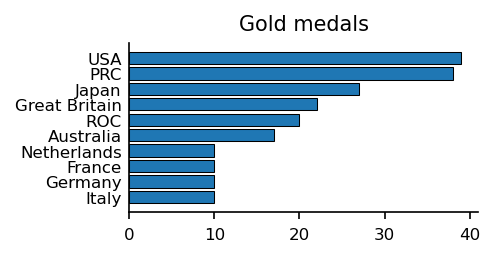

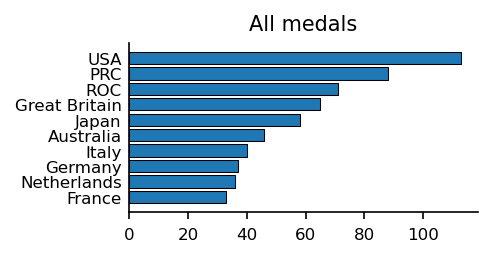

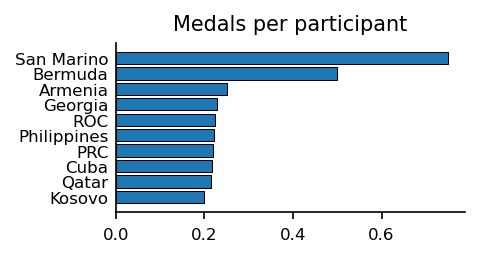

In [5]:
plt.figure(figsize=(3,1.5), dpi=150)
plot_top_teams(plt.gca(), weights=(1,0,0), title="Gold medals")

plt.figure(figsize=(3,1.5), dpi=150)
plot_top_teams(plt.gca(), weights=(1,1,1), title="All medals")

plt.figure(figsize=(3,1.5), dpi=150)
plot_top_teams(plt.gca(), weights=(1,1,1), normalize='nparticipants', title="Medals per participant")

That looks good. If you are wondering, PRC stands for People's Republic of China, and ROC for Russian Olympic Committee. And well done, San Marino and Bermuda!

### 3.2 Number of participants

Now let's do the number of participants in men's and women's competitions. We will create two scatterplots (one full, one zoomed-in). In the scatterplots, we want to annotate the interesting off-diagonal elements. We place the annotations by hand to make sure it is visually clear.

We color the points based on the ratio of men and women competing. What to do with the colorbar then? To make sure it will not resize the panel itself, we place it another axes that we create beforehand.

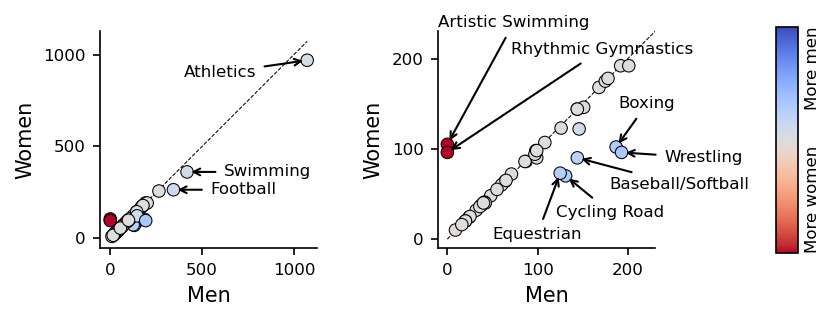

In [6]:
def plot_participants(ax, lim=None, annot_nparticipants=0, annot_imbalance=0.0, annot_shift=(0,0),
                      annot_pos=None, cbar_axes=None):
    """
    Scatterplot of number of participants per discipline for men and women. Annotations are added to 
    disciplines that satisfies given criteria.
    
    Args:
        ax:                   Matplotlib axes to plot in.
        lim:                  Limits of the plot.
        annot_nparticipants:  Minimum number of participants (either men or women) to be annotated.
        annot_imbalance:      Minimum imbalance in a discipline to be annotated.
        annot_shift:          Shift of the annotation from the data point, in data coordinates. 
                              Is overridden if the element is in annot_pos dict.
        annot_pos:            Dictionary directly specifying position of any annotation, if needed.
        cbar_axes:            Matplotlib axes to plot the colorbar in (optional).
    """
    plt.sca(ax)
    
    # Load data
    df = pd.read_excel("./data/EntriesGender.xlsx", engine='openpyxl')
    
    # Scatter plot
    s = plt.scatter(df.Male, df.Female, c=(df.Male)/(df.Male+df.Female), cmap='coolwarm_r', vmin=0, vmax=1, 
                    ec='k', lw=0.5)
    max_participants = df[['Male', 'Female']].to_numpy().max()
    plt.plot([0, max_participants], [0, max_participants], color='k', ls='--', zorder=-5, lw=0.5)
    if lim:
        plt.xlim(lim)
        plt.ylim(lim)
    else:
        lim = (-np.inf, np.inf)
    
    plt.xlabel("Men")
    plt.ylabel("Women")

    # Annotations
    imbalance = np.abs(df.Male / (df.Male + df.Female) - 0.5)
    nparticipants = df[['Male', 'Female']].max(axis=1)
    dff = df[(imbalance > annot_imbalance) & (nparticipants > annot_nparticipants)
             & (lim[0] < nparticipants) & (nparticipants < lim[1])]
    dff = dff.sort_values('Male')
    
    if annot_pos is None:
        annot_pos = {}
    
    for i, row in enumerate(dff.itertuples()):
        if lim is None or max(row.Male, row.Female) < lim[1]:
            pos = annot_pos.get(row.Discipline, (row.Male+annot_shift[0], row.Female+annot_shift[1]))
            plt.annotate(row.Discipline, xy=(row.Male, row.Female), xytext=pos, textcoords='data',
                         arrowprops={'arrowstyle': '->'}, fontsize=SMALL_SIZE, va='center')
   
    ax.set_aspect('equal', adjustable='box')
    plt.locator_params(axis="both", nbins=3)
    plot.axbottomleft(ax)
   
    # Add colorbar if needed
    if cbar_axes:
        cbar = plt.colorbar(mappable=s, cax=cbar_axes, ticks=[0,1])
        cbar.ax.set_yticklabels(['More women', 'More men'], rotation='vertical')
        cbar.ax.tick_params(length=0)
        ticklabels = cbar.ax.get_yticklabels()
        ticklabels[0].set_va("bottom")
        ticklabels[1].set_va("top")

    return s
    
    
zoom = (-10, 230)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,2), dpi=150,
                                    gridspec_kw={'width_ratios': [1,1,0.1], 'wspace': 0.8})

plot_participants(ax1, lim=None, annot_imbalance=0.02, annot_nparticipants=230, annot_shift=(200,0),
                  annot_pos={'Athletics': (400,900)})
   
plot_participants(ax2, lim=zoom, annot_imbalance=0.1, cbar_axes=ax3,
                  annot_pos={'Artistic Swimming': (-10,240), 'Rhythmic Gymnastics': (70,210),
                             'Cycling Road': (120,30), 'Baseball/Softball': (180,60),
                             'Equestrian': (50,5), 'Boxing': (190,150), 'Wrestling': (240,90)})

No men at all in artistic swimming and rhythmic gymnastics! What a surprise.

### 3.3 Embedding sketches or graphics

Often times we have a drawn sketch or existing graphics that we want to include in the figure. What then? Still no need to abandon our resolve to do everything in Matplotlib! We can just load the graphics and plot it inside our figure. That is easy to do for png files (see below), with vector graphics such as svg or pdf it is more trickier, so we will stick with the png file here.

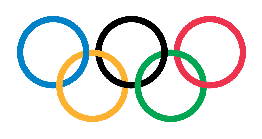

In [7]:
def plot_circles(ax):
    """
    Plot olympics circles to the given axes.
    """
    
    png = plt.imread('./data/1024px-Olympic_rings_without_rims.svg.png')
    plt.sca(ax)
    im = plt.imshow(png, interpolation='none')
    plt.axis('off')    
    pad = 10
    plt.xlim(-pad, png.shape[1]+pad)
    plt.ylim(png.shape[0]+pad, -pad)    
    
plt.figure(figsize=(2,1), dpi=150)
plot_circles(plt.gca())

## 4. Figure layout

Now, we will place the different panels on the figure. Let us not bother with the content for now, empty axes will suffice. 

Read about the [different options how to do the layouting](https://matplotlib.org/stable/tutorials/intermediate/gridspec.html) in Matplotlib. Different functions are useful for different arrangements; the tools that you should definitely know are:
- `plt.subplot()` and `plt.subplots()`: regular grid of axes.
- `fig.add_axes()`: places a new axes wherever in the figure you specify.
- `matplotlib.gridspec.Gridspec` and `fig.add_gridspec()`: grid of axes, but also allowing axes to span multiple columns and rows, and with variable widths and heights, as well as spacing between axes. Grispec is quite powerful for arranging the panels, and further note that you can add multiple gridspecs to the same figure, allowing you to do quite complex layouts. That can be handy e.g. when your panels have multiple subplots themselves.

In this case, we will go with three gridspecs: One for panel A (with a single subplot), one for panel B (with three subplots horizontally), and one for panel C (with three subplots vertically). The precise position of the gridspecs (given by `left`, `right`, `bottom`, and `top` arguments) is not important, we will adjust everything later. We will go with full-page width of the figure, so seven inches, and set the height so the layout looks correctly.

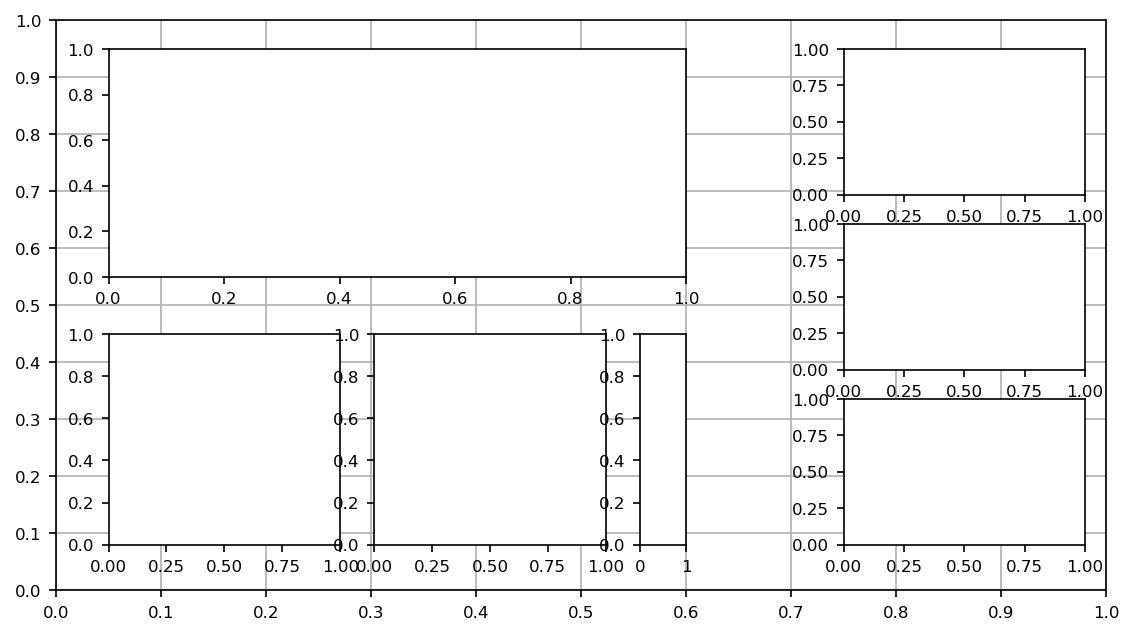

In [8]:
fig = plt.figure(figsize=(7., 3.8), dpi=150)

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.60, bottom=0.55, top=0.95)
gs2 = fig.add_gridspec(nrows=1, ncols=3, width_ratios=(1,1,0.2), left=0.05, right=0.60, bottom=0.08, top=0.45)
gs3 = fig.add_gridspec(nrows=3, ncols=1, left=0.75, right=0.98, bottom=0.08, top=0.95)

# Panel A
ax1 = plt.subplot(gs1[0])

# Panel B
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])
ax4 = plt.subplot(gs2[2])

# Panels C-E
ax5 = plt.subplot(gs3[0])
ax6 = plt.subplot(gs3[1])
ax7 = plt.subplot(gs3[2])

bg = plot.Background(visible=True)

That seems like it could work, if you have little imagination, or recall the sketch from above.

And what is the last call, you ask? The `Background` object from the helper library is basically just another axes, placed across the whole figure, and below all other axes. It has two purposes: First, the grid (which you see above) helps to better place the subplots if you directly specify the coordinates. Second, you can plot on it as on any other axes, which is occasionally helpful for various annotations, markers, or dividing lines, which you will see below.

Also, note that Jupyter notebook shows you everything even if it is outside of the figure. If I would save this figure now, only the stuff inside the outermost axes will be there - not the outer ticks and labels. The `Background` is therefore also helpful to see what will get cropped.

## 5. Put the content in

Now, the easy part. We have the layout, we have the plotting functions, so let's just put it together.

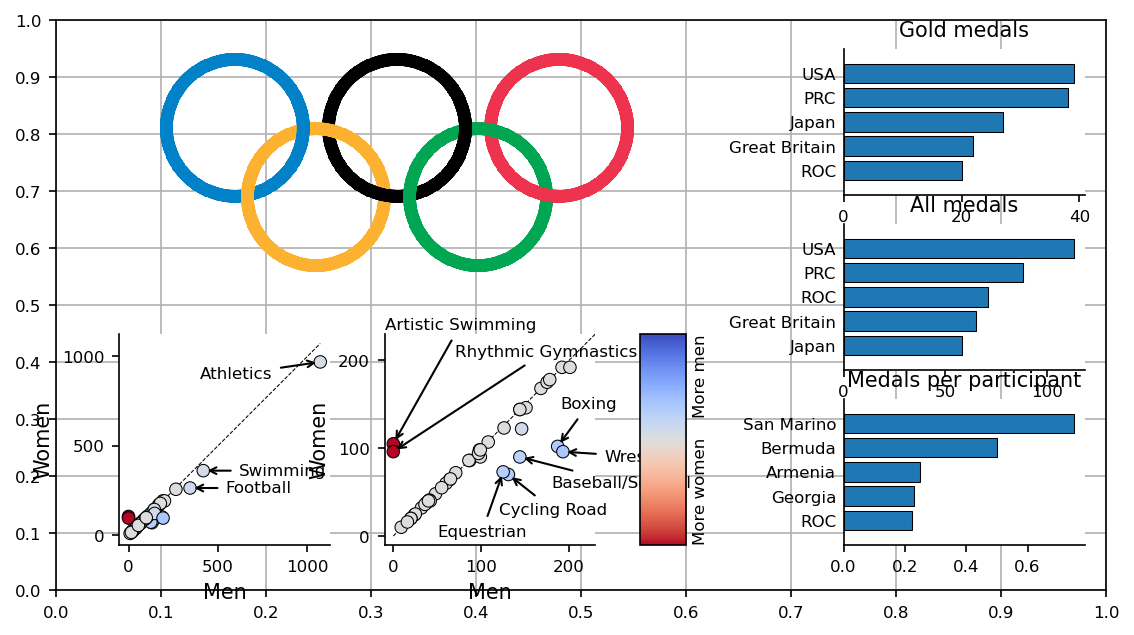

In [9]:
fig = plt.figure(figsize=(7., 3.8), dpi=150)

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.60, bottom=0.55, top=0.95)
gs2 = fig.add_gridspec(nrows=1, ncols=3, width_ratios=(1,1,0.2), left=0.05, right=0.60, bottom=0.08, top=0.45)
gs3 = fig.add_gridspec(nrows=3, ncols=1, left=0.75, right=0.98, bottom=0.08, top=0.95)

# Panel A
ax1 = plt.subplot(gs1[0])
plot_circles(ax1)

# Panel B
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])
ax4 = plt.subplot(gs2[2])

zoom = (-10, 230)
plot_participants(ax2, lim=None, annot_imbalance=0.02, annot_nparticipants=230, annot_shift=(200,0),
                  annot_pos={'Athletics': (400,900)})
plot_participants(ax3, lim=zoom, annot_imbalance=0.1,  cbar_axes=ax4,
                  annot_pos={'Artistic Swimming': (-10,240), 'Rhythmic Gymnastics': (70,210),
                             'Cycling Road': (120,30), 'Baseball/Softball': (180,60),
                             'Equestrian': (50,5), 'Boxing': (190,150), 'Wrestling': (240,90)})

# Panels C-E
ax5 = plt.subplot(gs3[0])
ax6 = plt.subplot(gs3[1])
ax7 = plt.subplot(gs3[2])

plot_top_teams(ax5, n=5, weights=(1,0,0), title="Gold medals")
plot_top_teams(ax6, n=5, weights=(1,1,1), title="All medals")
plot_top_teams(ax7, n=5, weights=(1,1,1), normalize='nparticipants', title="Medals per participant")

# Background
bg = plot.Background(visible=True)

Ok, we are getting closer. Sure, it is a mess now with the overlapping captions and the labels outside of the figure, but it can fixed with a bit of shuffling and spacing adjustment. Sometimes, however, it is at this stage that you realize that the layout just does not work. Do not despair: Come up with new one and populate it with the same plotting functions you already have.

## 6. Adjust the spacing


Now comes the boring part: adjustment of the spacing so nothing overlaps and there is enough space where it needs to be. Specifically, we play with the arguments of `fig.add_gridspec()`: `left`, `right`, `top`, `bottom` setting the gridspec limits, `hspace` and `wspace` setting the spacing, and `width_ratios` setting the subplot sizes.

This can get bit tedious. Avoid it as much as you can can by using regular grids, and by doing the adjustment only when you are done with everything else.

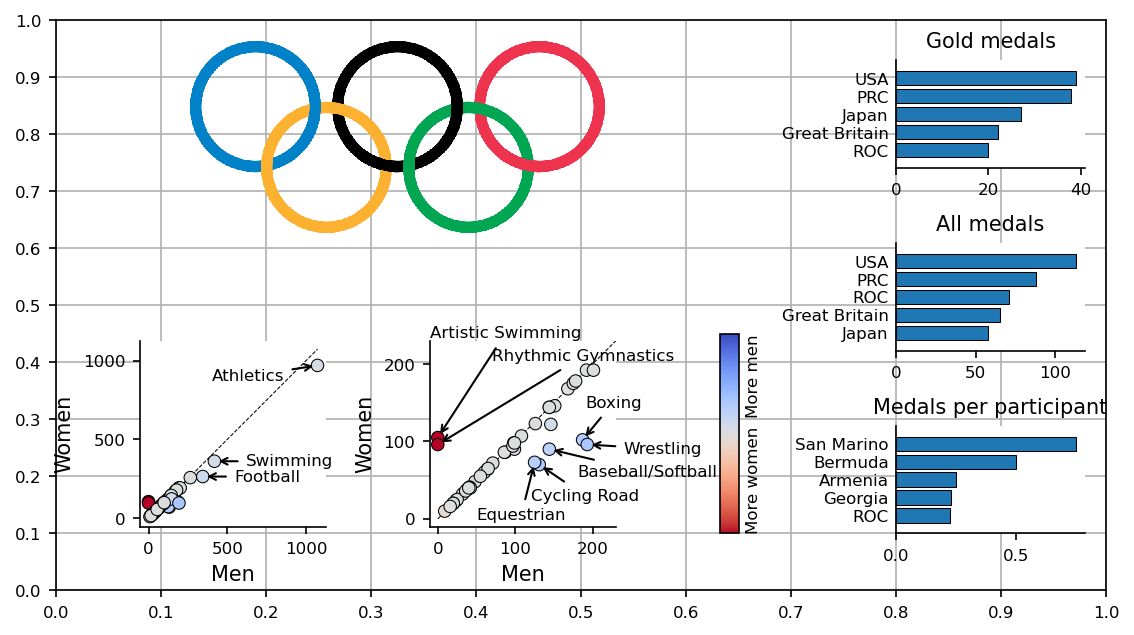

In [10]:
fig = plt.figure(figsize=(7., 3.8), dpi=150)

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.0, right=0.65, bottom=0.62, top=0.97)
gs2 = fig.add_gridspec(nrows=1, ncols=3, left=0.08, right=0.65, bottom=0.1, top=0.45,
                       width_ratios=(1,1,0.1), wspace=0.8)
gs3 = fig.add_gridspec(nrows=3, ncols=1, left=0.8, right=0.98, bottom=0.1, top=0.93, hspace=0.7)

# Panel A
ax1 = plt.subplot(gs1[0])
plot_circles(ax1)

# Panel B
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])
ax4 = plt.subplot(gs2[2])

zoom = (-10, 230)
plot_participants(ax2, lim=None, annot_imbalance=0.02, annot_nparticipants=230, annot_shift=(200,0),
                  annot_pos={'Athletics': (400,900)})
plot_participants(ax3, lim=zoom, annot_imbalance=0.1,  cbar_axes=ax4,
                  annot_pos={'Artistic Swimming': (-10,240), 'Rhythmic Gymnastics': (70,210),
                             'Cycling Road': (120,30), 'Baseball/Softball': (180,60),
                             'Equestrian': (50,5), 'Boxing': (190,150), 'Wrestling': (240,90)})

# Panels C-E
ax5 = plt.subplot(gs3[0])
ax6 = plt.subplot(gs3[1])
ax7 = plt.subplot(gs3[2])

plot_top_teams(ax5, n=5, weights=(1,0,0), title="Gold medals")
plot_top_teams(ax6, n=5, weights=(1,1,1), title="All medals")
plot_top_teams(ax7, n=5, weights=(1,1,1), normalize='nparticipants', title="Medals per participant")

# Background
bg = plot.Background(visible=True)

Much better!

## 7. Add labels and annotations

And now some final improvements: 
- Adding the panel labels using the helper function `plot.add_panel_letters()`;
- Adding the title for panel B, which we plot on the background axes;
- Adding the lines between panels for easier visual orientation with `plot.vline()` and `plot.hline()` helper functions ;
- Showing the zoomed-in region on the left side of panel B;
- Turnning of the background grid through `visible=False`.

Finally, we save the figure to pdf.

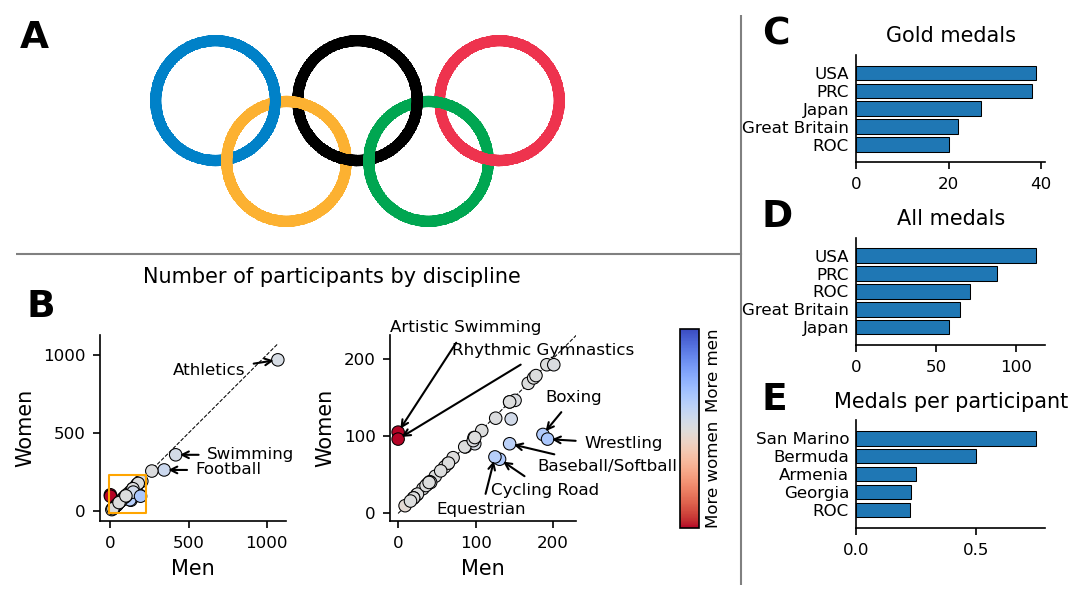

In [11]:
fig = plt.figure(figsize=(7., 3.8), dpi=150)

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.0, right=0.65, bottom=0.62, top=0.97)
gs2 = fig.add_gridspec(nrows=1, ncols=3, left=0.08, right=0.65, bottom=0.1, top=0.45,
                       width_ratios=(1,1,0.1), wspace=0.8)
gs3 = fig.add_gridspec(nrows=3, ncols=1, left=0.8, right=0.98, bottom=0.1, top=0.93, hspace=0.7)

# Panel A
ax1 = plt.subplot(gs1[0])
plot_circles(ax1)

# Panel B
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])
ax4 = plt.subplot(gs2[2])

zoom = (-10, 230)
plot_participants(ax2, lim=None, annot_imbalance=0.02, annot_nparticipants=230, annot_shift=(200,0),
                  annot_pos={'Athletics': (400,900)})
plot_participants(ax3, lim=zoom, annot_imbalance=0.1,  cbar_axes=ax4,
                  annot_pos={'Artistic Swimming': (-10,240), 'Rhythmic Gymnastics': (70,210),
                             'Cycling Road': (120,30), 'Baseball/Softball': (180,60),
                             'Equestrian': (50,5), 'Boxing': (190,150), 'Wrestling': (240,90)})

# Panel C-E
ax5 = plt.subplot(gs3[0])
ax6 = plt.subplot(gs3[1])
ax7 = plt.subplot(gs3[2])

plot_top_teams(ax5, n=5, weights=(1,0,0), title="Gold medals")
plot_top_teams(ax6, n=5, weights=(1,1,1), title="All medals")
plot_top_teams(ax7, n=5, weights=(1,1,1), normalize='nparticipants', title="Medals per participant")

# Background, labels, and annotations
bg = plot.Background(visible=False)
plot.add_panel_letters(fig, axes=[ax1, ax2, ax5, ax6, ax7], fontsize=18,
                       xpos=[-0.3,-0.4,-0.5,-0.5,-0.5], ypos=[0.92, 1.1, 1.1, 1.1, 1.1])
bg.axes.text(0.3, 0.53, "Number of participants by discipline", ha='center', fontsize=MEDIUM_SIZE)
bg.hline(0.58, x0=0, x1=0.69)
bg.vline(0.69, y0=0, y1=1)


# Indicate the zoomed-in region on panel B
plt.sca(ax2)
plt.plot([zoom[0], zoom[1], zoom[1], zoom[0], zoom[0]], [zoom[0], zoom[0], zoom[1], zoom[1], zoom[0]],
         color='orange', lw=1)

# And save it. 
plt.savefig("tokyo2020.pdf")

And we are done!

## Other reading

Matplotlib-focused:
- Matplotlib tutorials: https://matplotlib.org/stable/tutorials/index.html
- Scipy lecture notes on Matplotlib: https://scipy-lectures.org/intro/matplotlib/index.html
- Plotting in python4astronomers: https://python4astronomers.github.io/plotting/plotting.html


On data visualization generally (freely-accessible):

- Claus O. Wilke: Fundamentals of Data Visualization. https://clauswilke.com/dataviz/.
